(512, 512)


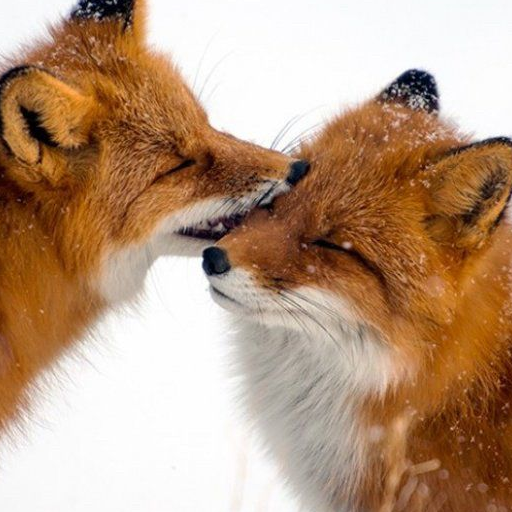

In [34]:
from PIL import Image
from io import BytesIO
import torchvision.transforms as T
import requests

URL="https://github.com/geronimi73/3090_shorts/blob/main/assets/3.jpg?raw=True"

image = Image.open(BytesIO(requests.get(URL).content))

# Crop a 512x512 image from the center
# AE downsizes image by factor 32 dc-ae-f32c32-sana-1.0-diffusers
# -> image dimensions must be a multiple of 32!
image = T.CenterCrop(512)(image)

print(image.size)
image

In [8]:
import torch
from diffusers import AutoencoderDC

dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

dcae = AutoencoderDC.from_pretrained(
    "Efficient-Large-Model/Sana_600M_1024px_diffusers", 
    subfolder="vae", 
    torch_dtype=dtype
).to(device)

In [31]:
# Convert the image to a tensor and normalize mean and std.
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# convert, change dtype to bfloat16, and put on device 
latent = transform(image)[None].to(device).to(dtype)

# convert to latent
with torch.no_grad():
    latent = dcae.encode(latent).latent
latent.shape

torch.Size([1, 32, 16, 16])

In [48]:
[ 
    latent.min().item(),latent.max().item(), 
    latent.mean().item(), latent.std().item()
]

[-17.125, 11.0, 0.10107421875, 2.359375]

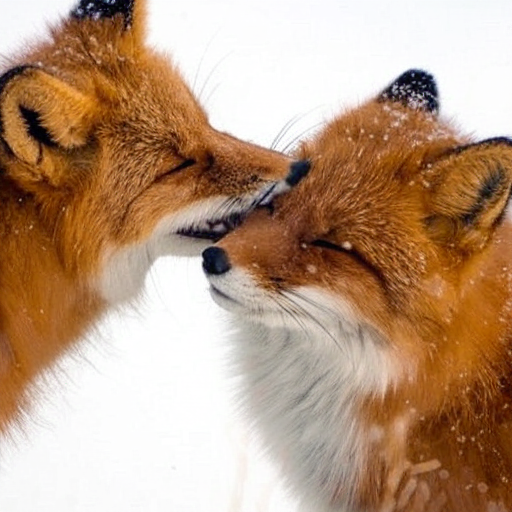

In [55]:
with torch.no_grad():
    image_roundtrip = dcae.decode(latent).sample.to("cpu")

# Normalize autoencoder output back to 0-1 and transform to image
image_roundtrip = torch.clamp_(image_roundtrip[0,:], -1, 1)
image_roundtrip = image_roundtrip * 0.5 + 0.5
image_roundtrip = T.ToPILImage()(image_roundtrip.float())
image_roundtrip

In [50]:
[ 
    image_out.min().item(),image_out.max().item(), 
    image_out.mean().item(), image_out.std().item()
]

[0.0, 1.0, 0.61328125, 0.330078125]

In [37]:
T.Normalize?

Init signature: T.Normalize(mean, std, inplace=False)
Docstring:     
Normalize a tensor image with mean and standard deviation.
This transform does not support PIL Image.
Given mean: ``(mean[1],...,mean[n])`` and std: ``(std[1],..,std[n])`` for ``n``
channels, this transform will normalize each channel of the input
``torch.*Tensor`` i.e.,
``output[channel] = (input[channel] - mean[channel]) / std[channel]``

.. note::
    This transform acts out of place, i.e., it does not mutate the input tensor.

Args:
    mean (sequence): Sequence of means for each channel.
    std (sequence): Sequence of standard deviations for each channel.
    inplace(bool,optional): Bool to make this operation in-place.
Init docstring: Initialize internal Module state, shared by both nn.Module and ScriptModule.
File:           ~/.local/lib/python3.10/site-packages/torchvision/transforms/transforms.py
Type:           type
Subclasses:     